In [3]:
import best

In [104]:
import scipy

In [109]:
from scipy import optimize

In [4]:
import matplotlib.pyplot as plt

In [44]:
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')
plt.rcParams['figure.figsize'] = [12, 8]

In [5]:
import numpy as np

In [6]:
import pathlib

In [8]:
import yaml

In [7]:
directory = pathlib.Path('resultssumfg1102/h3500s3500b3500/')

In [9]:
values_file = 'configurations/config_plotting.yaml' 
with open(values_file, 'r') as stream:
            data = yaml.safe_load(stream)

In [10]:
estimators_dictionary = data['estimators']
estimators = list(estimators_dictionary.keys())

In [11]:
lmin_sel, lmax_sel = data['lmin_sel'], data['lmax_sel']

optversion = data['optversion']

In [12]:
analysis_directory = data['analysisdirectory']
PP = pathlib.Path(analysis_directory)

In [13]:
lmax_directory = 'h3500s3500b3500'

In [14]:
P = PP/lmax_directory

In [16]:
nu = estimators_dictionary[estimators[0]]['nu']
del estimators_dictionary
getoutname = lambda key: f'{key}_{nu}.npy'

In [21]:
kg = np.load(P/getoutname('kg'))
kk = np.load(P/getoutname('kk'))
gg = np.load(P/getoutname('gg'))
ells = np.load(P/getoutname('ells'))
noises = np.load(P/getoutname('N'))
theta = np.load(P/getoutname('theta'))
thetacross = np.load(P/getoutname('thetacross'))

In [22]:
biases = np.load(P/getoutname('sum_all_totalabsbias'))
biasescross = np.load(P/getoutname('sum_all_crosstotalabsbias'))

In [23]:
Optimizerkk = best.Opt(estimators, lmin_sel, lmax_sel, ells, kk, theta, biases, noises)

In [33]:
resultkk = best.Res()
biases = resultkk.load(directory, f'biases')

Optimizerkk.biases_selected = biases

In [34]:
fnb_getter = lambda Opt, fb_val: Opt.get_f_n_b(Opt.ells_selected, Opt.theory_selected, Opt.theta_selected, Opt.biases_selected,
                              sum_biases_squared = False, bias_squared = False, fb = fb_val, inv_variance = False)

In [126]:
fbs = [0., 0.01, 0.05, 0.1, 0.5, 1., 2., 5., 10., 100.]
fbs = np.array(fbs)

In [42]:
ns = np.array([])
bs = np.array([])
fs = np.array([])

In [43]:
for fb in fbs:
    f, n, b = fnb_getter(Optimizerkk, fb)
    resultkk.load_all(directory, f'auto_fb_{fb}')
    ns = np.append(ns, n(resultkk.x))
    bs = np.append(bs, b(resultkk.x))
    fs = np.append(fs, f(resultkk.x))

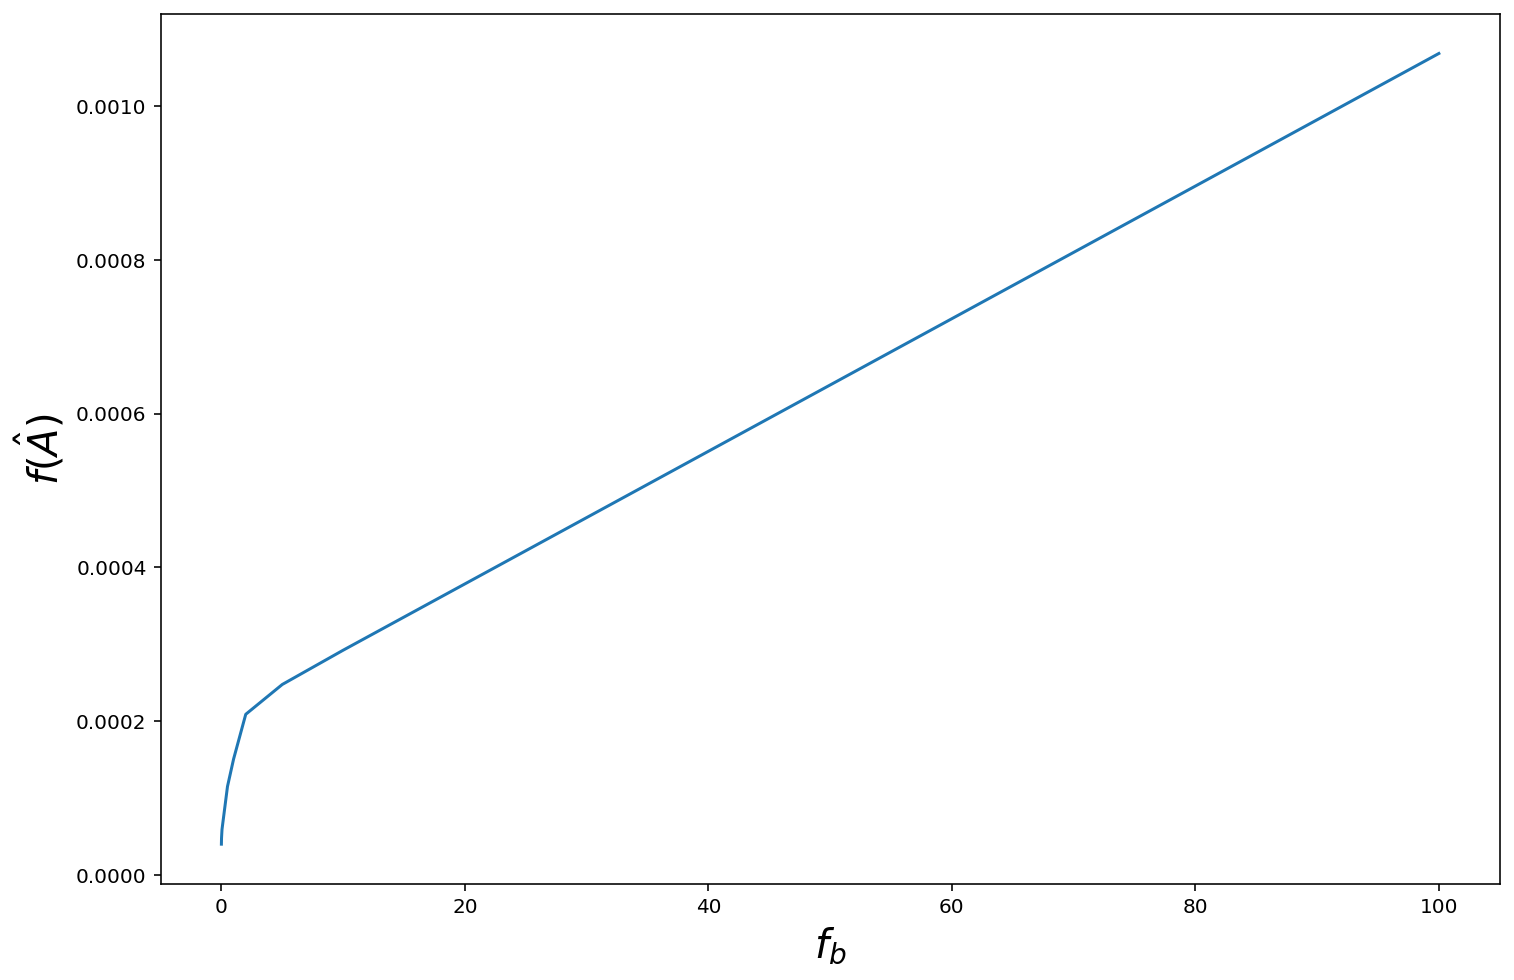

In [118]:
plt.ylabel('$f(\hat{A})$', size = 20)
plt.xlabel('$f_b$', size = 20)
plt.plot(fbs, fs)

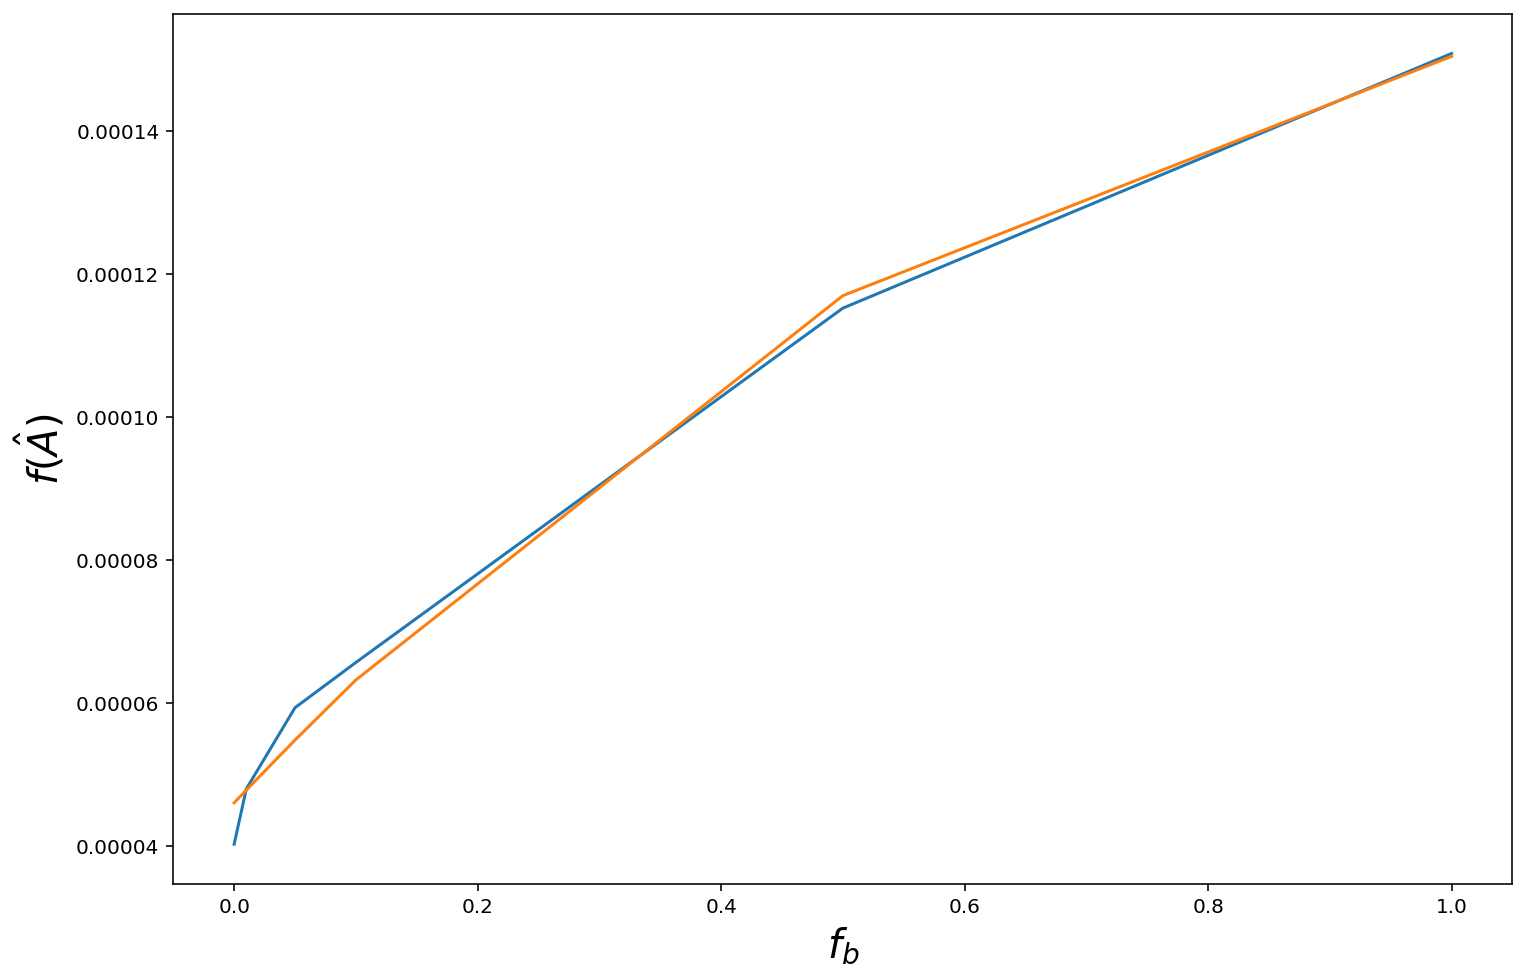

In [153]:
plt.ylabel('$f(\hat{A})$', size = 20)
plt.xlabel('$f_b$', size = 20)
plt.plot(fbs[fbs<2], fs[fbs<2])

p = np.poly1d(np.polyfit(fbs[fbs<2], fs[fbs<2], 2))
plt.plot(fbs[fbs<2], p(fbs[fbs<2]))

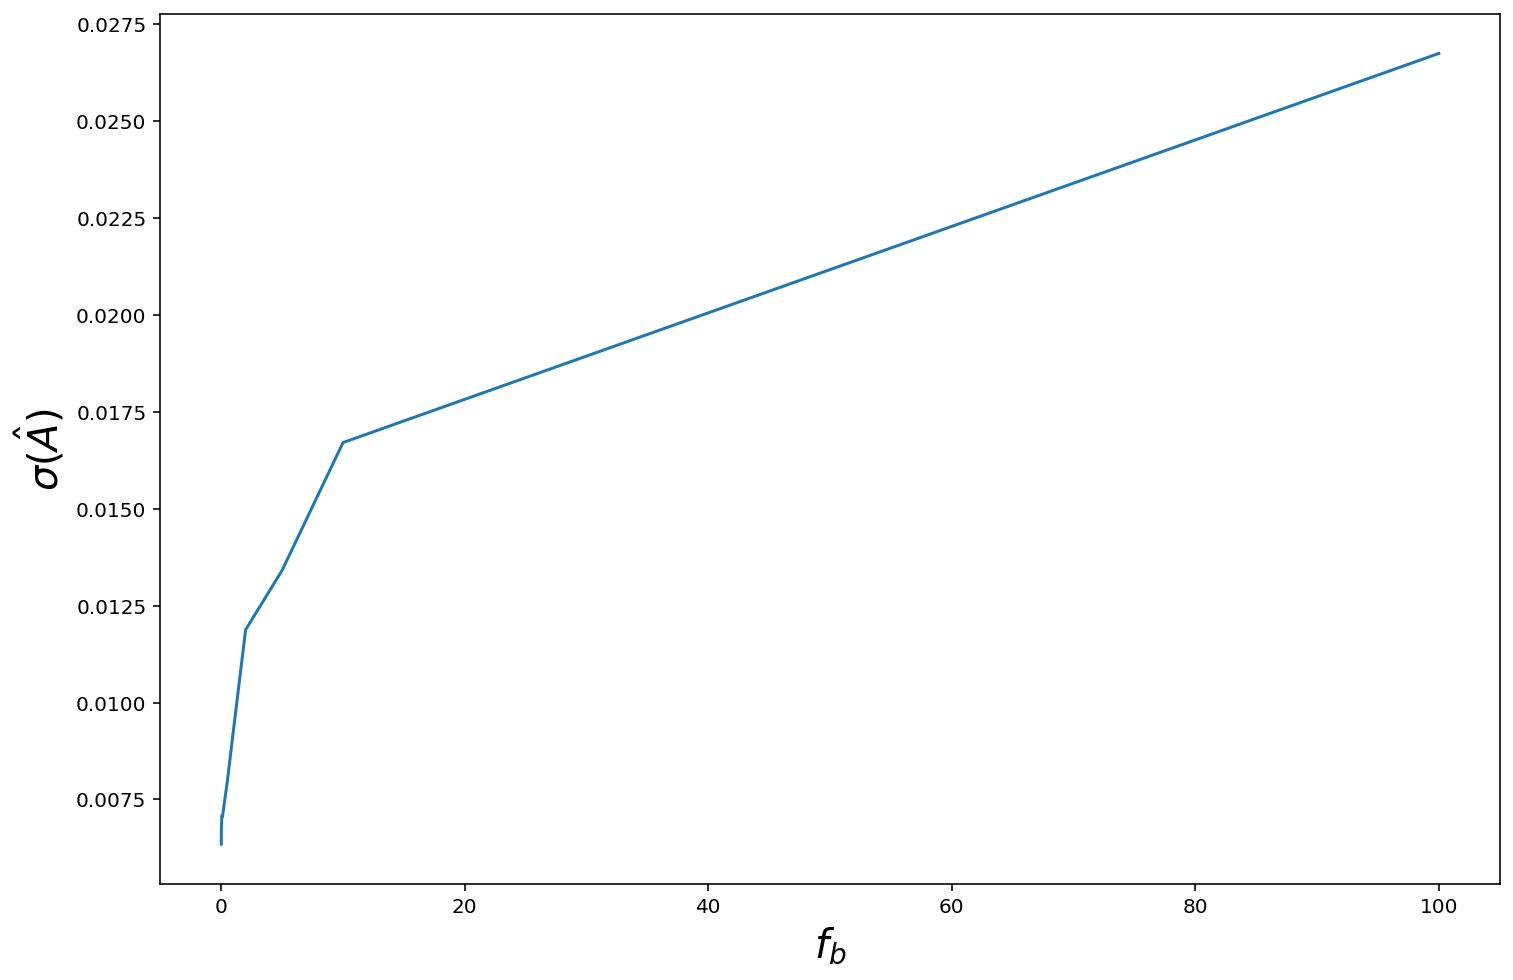

In [119]:
plt.ylabel('$\\sigma(\hat{A})$', size = 20)
plt.xlabel('$f_b$', size = 20)
plt.plot(fbs, ns)

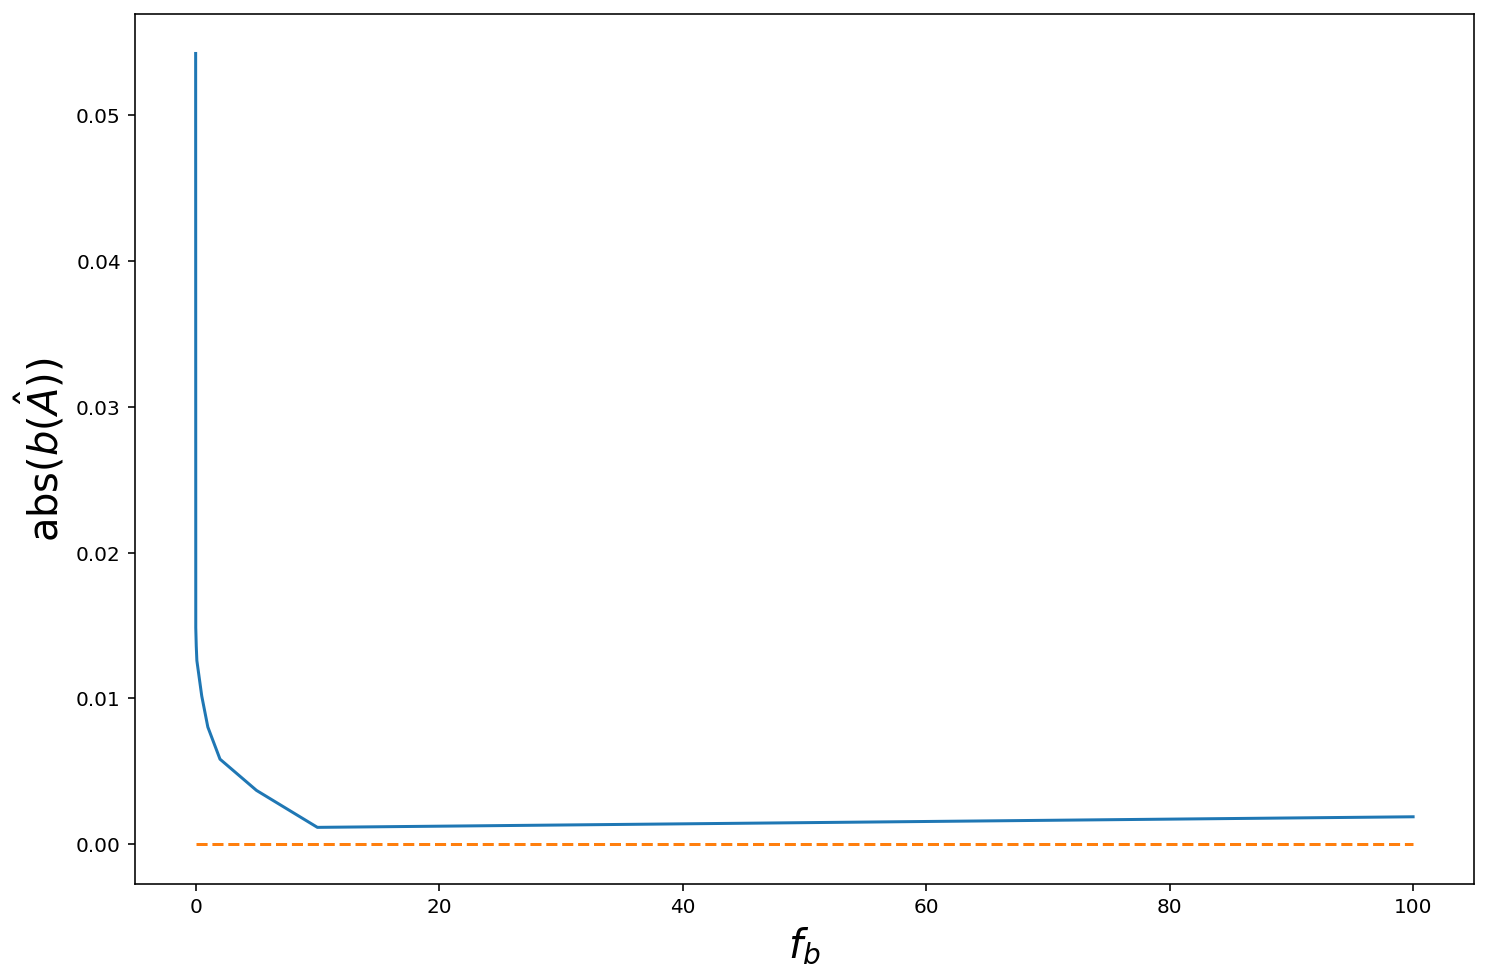

In [125]:
plt.ylabel('abs$(b(\hat{A}))$', size = 20)
plt.xlabel('$f_b$', size = 20)
plt.plot(fbs, abs(bs))
plt.plot(fbs, np.array(fbs)*0., ls = '--')

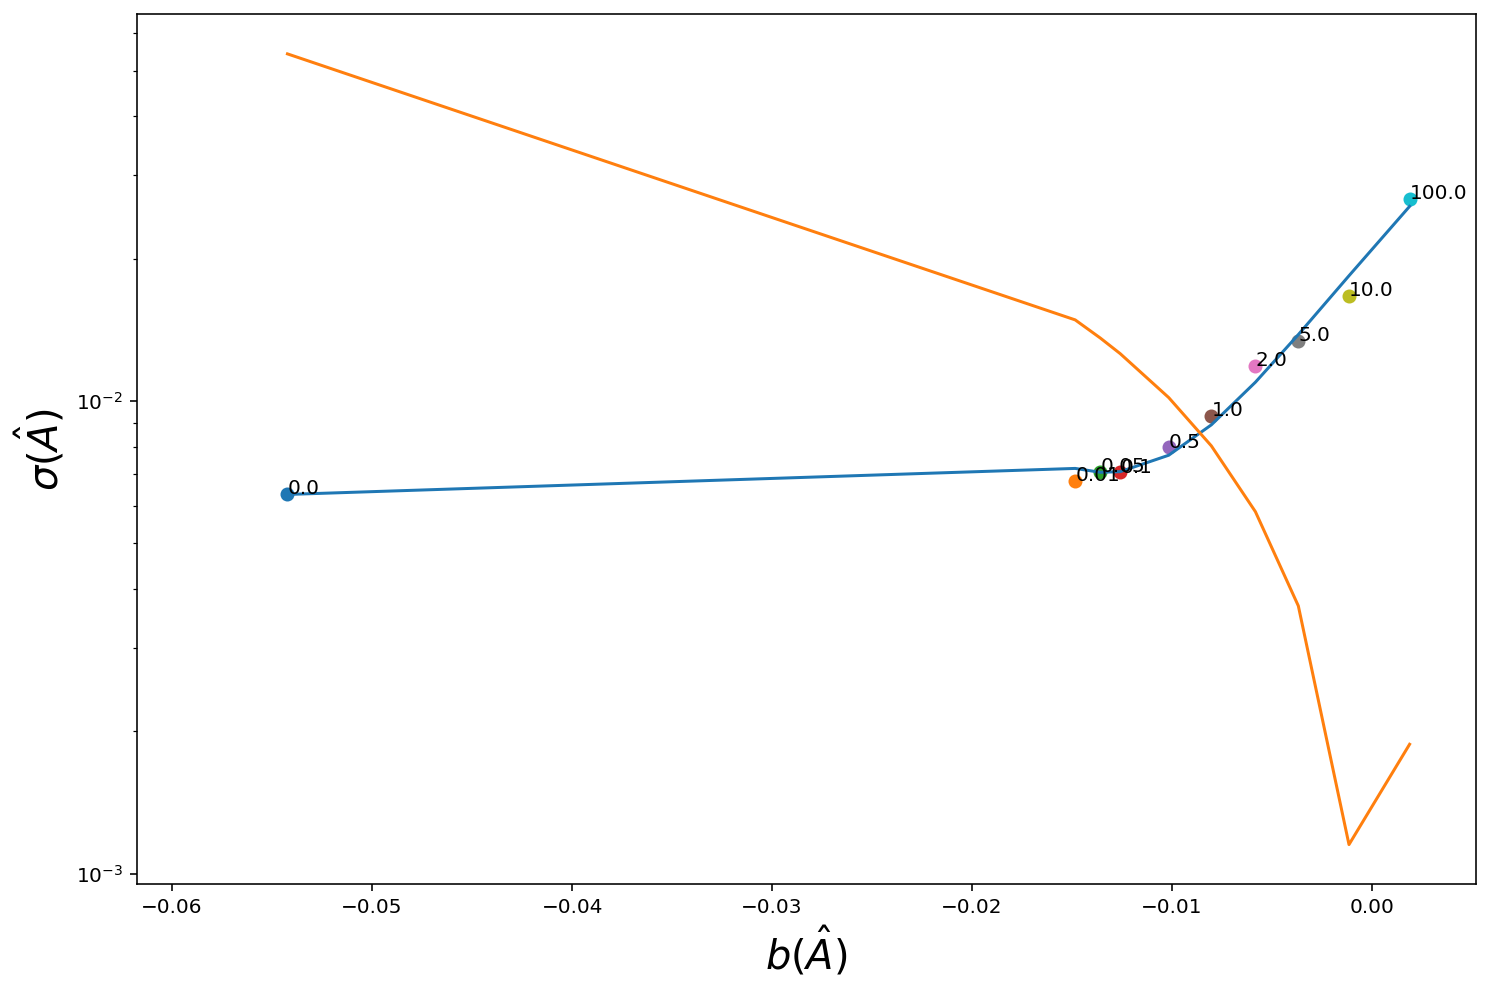

In [155]:
fig, ax = plt.subplots()

ax.set_ylabel('$\\sigma(\hat{A})$', size = 20)
ax.set_xlabel('$b(\hat{A})$', size = 20)

for i, c in enumerate(zip(bs, ns)):
    b, n = c
    ax.scatter(b, n)
    ax.annotate(fbs[i], (b, n))

p = np.poly1d(np.polyfit(bs, ns, 3))
plt.plot(bs, p(bs))
#ax.legend(loc = 'best')

ax.plot(bs, abs(bs))
#plt.plot(-ns, abs(ns))
plt.yscale('log')

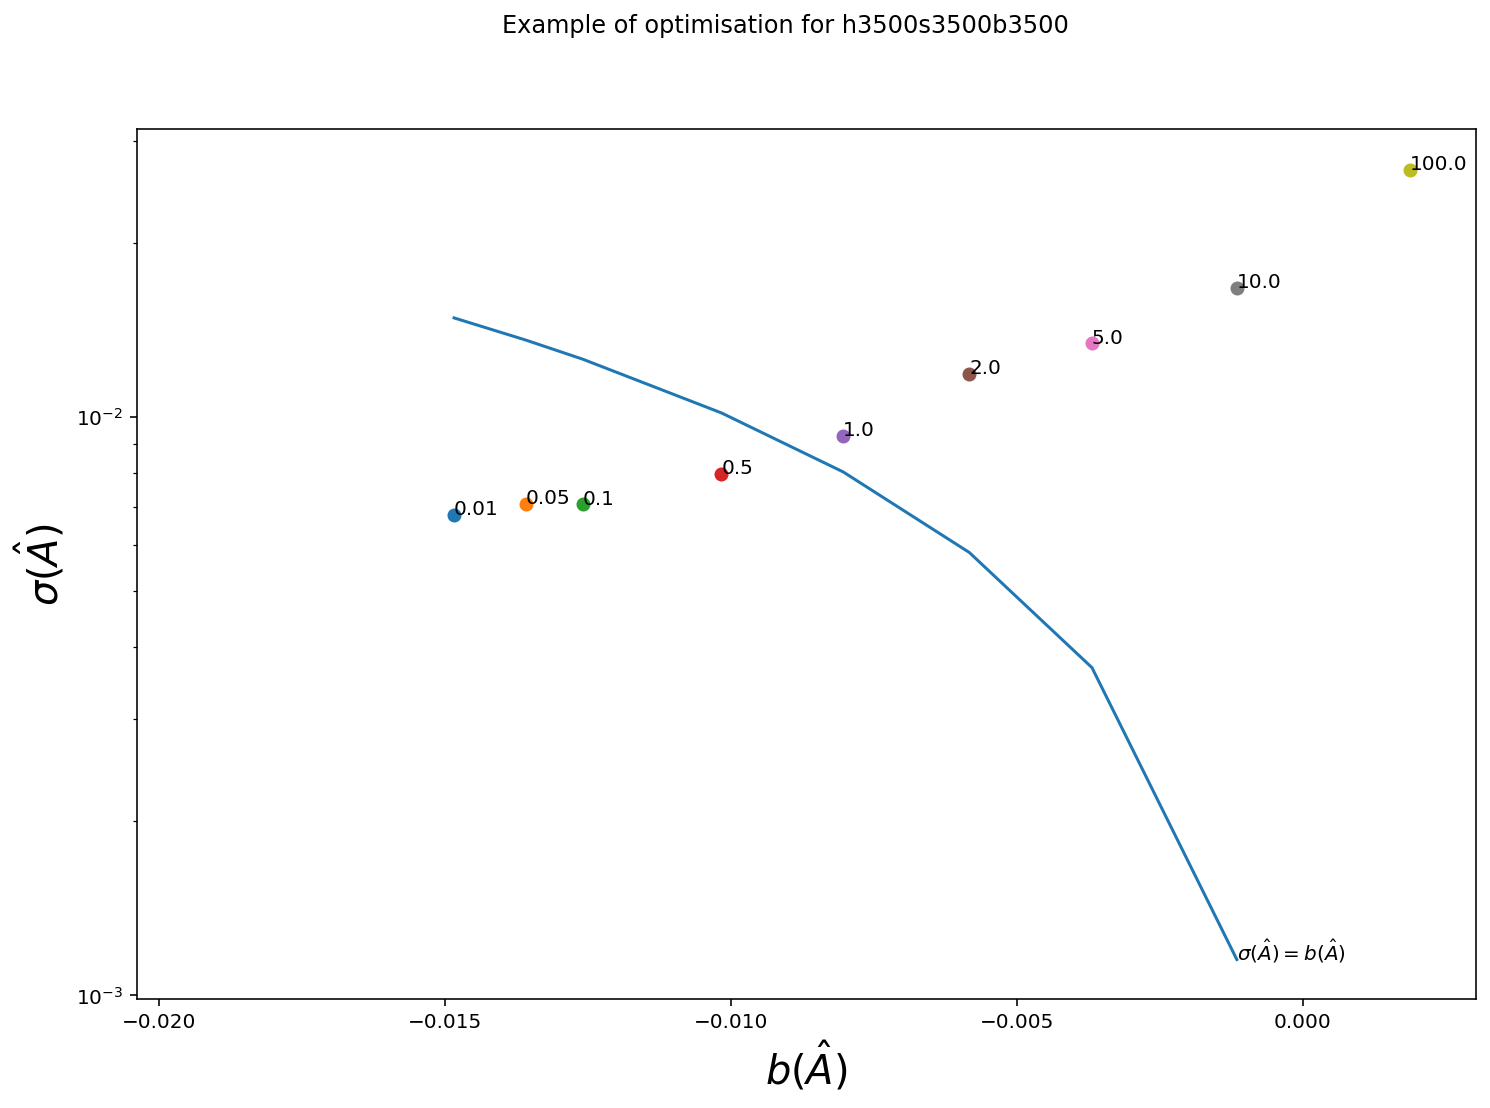

In [103]:
fig, ax = plt.subplots()

fig.suptitle(f'Example of optimisation for {lmax_directory}')

ax.set_ylabel('$\\sigma(\hat{A})$', size = 20)
ax.set_xlabel('$b(\hat{A})$', size = 20)

bottom = 1

for i, c in enumerate(zip(bs[bottom:], ns[bottom:])):
    b, n = c
    ax.scatter(b, n)
    ax.annotate(fbs[i+bottom], (b, n))

#ax.legend(loc = 'best')

ax.plot(bs[bottom:-1], abs(bs[bottom:-1]))
ax.annotate('$\\sigma(\hat{A}) = b(\hat{A})$', (bs[-2], abs(bs[-2])))
#plt.plot(-ns, abs(ns))
plt.yscale('log')

In [127]:
def get_corresponding_b_n(fb):
    index = list(fbs).index(fb)
    return bs[index], ns[index]


def reldifference(fb1, fb2):
    b1, n1 = get_corresponding_b_n(fb1)
    b2, n2 = get_corresponding_b_n(fb2)
    return abs(b1-b2)/abs(b1)*100, abs(n1-n2)/n1*100

In [97]:
get_corresponding_b_n(1.)

(-0.008035668755260038, 0.009288364460102285)

In [95]:
fb1, fb2 = 0., 1.
print(f'Relative difference between {fb1} {fb2} for bias and noise is {reldifference(fb1, fb2)}')

Relative difference between 0.0 1.0 for bias and noise is (85.18270965325472, 46.34233418811296)


In [96]:
fb1, fb2 = 0.1, 1.
print(f'Relative difference between {fb1} {fb2} for bias and noise is {reldifference(fb1, fb2)}')

Relative difference between 0.1 1.0 for bias and noise is (36.18558380488493, 31.570465224818705)


In [171]:
for fb in fbs:
    resultkk.load_all(directory, f'auto_fb_{fb}')
    d = resultkk.ws
    w1, w2, w3, w = d[:, 0], d[:, 1], d[:, 2], d[:, 3]

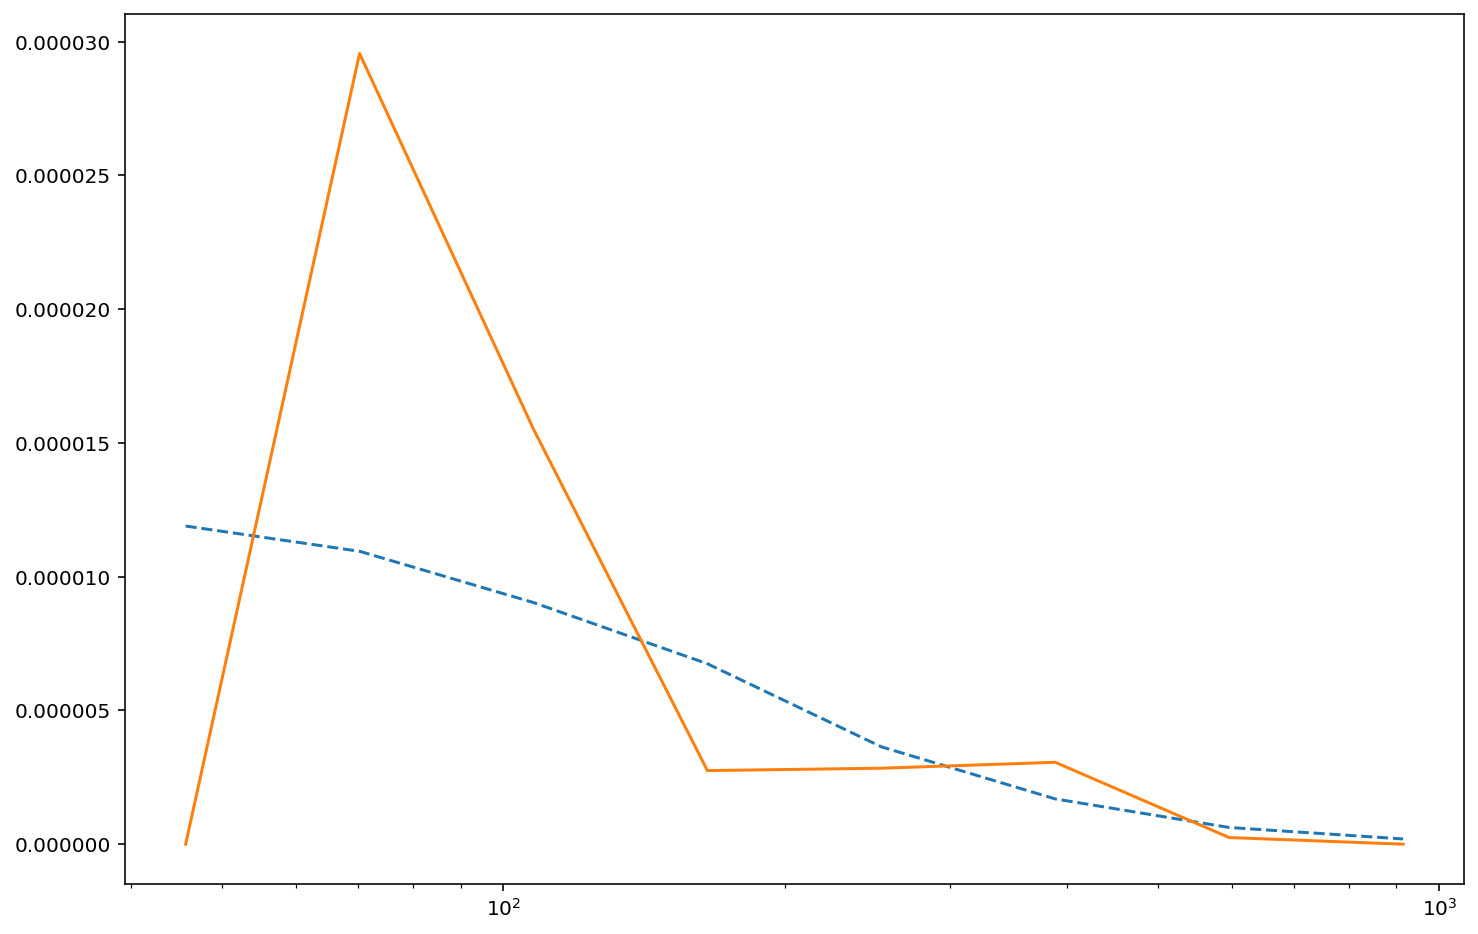

In [186]:
resultkk.load_all(directory, f'auto_fb_{0.}')
d = resultkk.ws
w1, w2, w3, w = d[:, 0], d[:, 1], d[:, 2], d[:, 3]
plt.plot(resultkk.ells, w, ls = '--')

resultkk.load_all(directory, f'auto_fb_{1.}')
d = resultkk.ws
w1, w2, w3, w = d[:, 0], d[:, 1], d[:, 2], d[:, 3]
plt.plot(resultkk.ells, w)

plt.xscale('log')

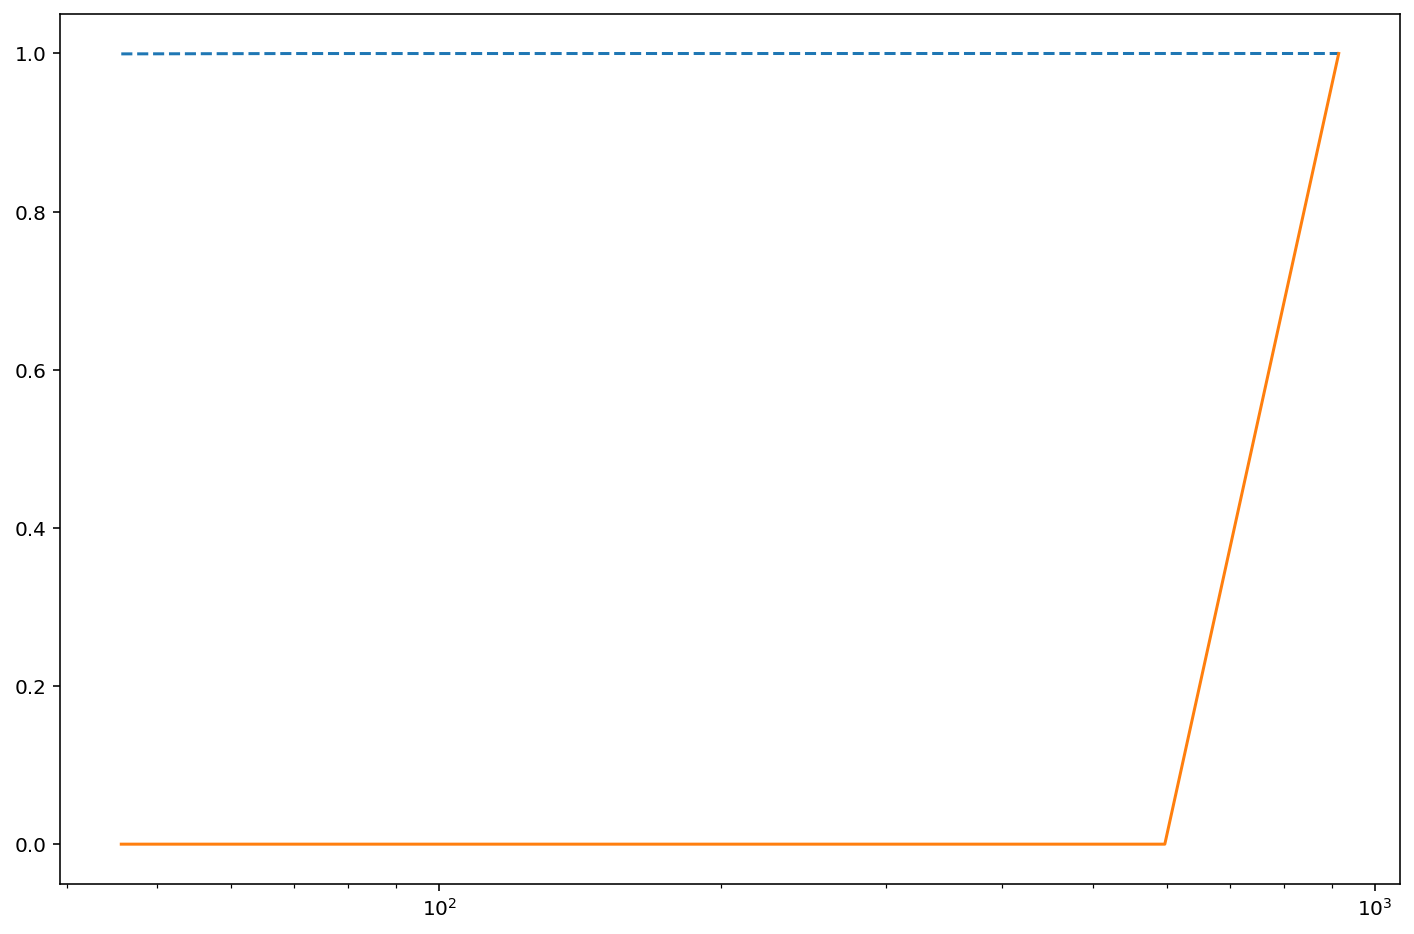

In [190]:
resultkk.load_all(directory, f'auto_fb_{0.}')
d = resultkk.ws
w1, w2, w3, w = d[:, 0], d[:, 1], d[:, 2], d[:, 3]
plt.plot(resultkk.ells, w1, ls = '--')

resultkk.load_all(directory, f'auto_fb_{.1}')
d = resultkk.ws
w1, w2, w3, w = d[:, 0], d[:, 1], d[:, 2], d[:, 3]
plt.plot(resultkk.ells, w1)

plt.xscale('log')